In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
# from YOLOv8_Explainer import yolov8_heatmap, display_images

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch, yaml, cv2, os, shutil, sys
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from tqdm import trange
from PIL import Image
from ultralytics.nn.tasks import attempt_load_weights
from ultralytics.utils.torch_utils import intersect_dicts
from ultralytics.utils.ops import xywh2xyxy, non_max_suppression
from pytorch_grad_cam import GradCAMPlusPlus, GradCAM, XGradCAM, EigenCAM, HiResCAM, LayerCAM, RandomCAM, EigenGradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from pytorch_grad_cam.activations_and_gradients import ActivationsAndGradients

def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, ratio, (dw, dh)

class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers, reshape_transform):
        self.model = model
        self.gradients = []
        self.activations = []
        self.reshape_transform = reshape_transform
        self.handles = []
        for target_layer in target_layers:
            self.handles.append(
                target_layer.register_forward_hook(self.save_activation))
            # Because of https://github.com/pytorch/pytorch/issues/61519,
            # we don't use backward hook to record gradients.
            self.handles.append(
                target_layer.register_forward_hook(self.save_gradient))

    def save_activation(self, module, input, output):
        activation = output

        if self.reshape_transform is not None:
            activation = self.reshape_transform(activation)
        self.activations.append(activation.cpu().detach())

    def save_gradient(self, module, input, output):
        if not hasattr(output, "requires_grad") or not output.requires_grad:
            # You can only register hooks on tensor requires grad.
            return

        # Gradients are computed in reverse order
        def _store_grad(grad):
            if self.reshape_transform is not None:
                grad = self.reshape_transform(grad)
            self.gradients = [grad.cpu().detach()] + self.gradients

        output.register_hook(_store_grad)

    def post_process(self, result):
        logits_ = result[:, 4:]
        boxes_ = result[:, :4]
        sorted, indices = torch.sort(logits_.max(1)[0], descending=True)
        return torch.transpose(logits_[0], dim0=0, dim1=1)[indices[0]], torch.transpose(boxes_[0], dim0=0, dim1=1)[indices[0]], xywh2xyxy(torch.transpose(boxes_[0], dim0=0, dim1=1)[indices[0]]).cpu().detach().numpy()

    def __call__(self, x):
        self.gradients = []
        self.activations = []
        model_output = self.model(x)
        post_result, pre_post_boxes, post_boxes = self.post_process(model_output[0])
        return [[post_result, pre_post_boxes]]

    def release(self):
        for handle in self.handles:
            handle.remove()

class yolov8_target(torch.nn.Module):
    def __init__(self, ouput_type, conf, ratio) -> None:
        super().__init__()
        self.ouput_type = ouput_type
        self.conf = conf
        self.ratio = ratio

    def forward(self, data):
        post_result, pre_post_boxes = data
        result = []
        # print(post_result.shape)
        # print(pre_post_boxes.shape)
        for i in trange(int(post_result.size(0) * self.ratio)):
            if float(post_result[i].max()) < self.conf:
                break
            if self.ouput_type == 'class' or self.ouput_type == 'all':
                result.append(post_result[i].max())
            elif self.ouput_type == 'box' or self.ouput_type == 'all':
                for j in range(4):
                    result.append(pre_post_boxes[i, j])
        return sum(result)

class yolov8_heatmap:
    def __init__(self, weight, device, method, layer, backward_type, conf_threshold, ratio, show_box, renormalize):
        device = torch.device(device)
        ckpt = torch.load(weight)
        model_names = ckpt['model'].names
        model = attempt_load_weights(weight, device)
        model.info()
        for p in model.parameters():
            p.requires_grad_(True)
        model.eval()

        target = yolov8_target(backward_type, conf_threshold, ratio)
        target_layers = [model.model[l] for l in layer]
        # method = eval(method)(model, target_layers, use_cuda=device.type == 'cuda')
        method = eval(method)(model, target_layers)
        method.activations_and_grads = ActivationsAndGradients(model, target_layers, None)

        colors = np.array([[240,113,105], [97,200,134]]).astype(int)
        self.__dict__.update(locals())

    def post_process(self, result):
        result = non_max_suppression(result, conf_thres=self.conf_threshold, iou_thres=0.65)[0]
        return result

    def draw_detections(self, box, color, name, img):
        xmin, ymin, xmax, ymax = list(map(int, list(box)))
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), tuple(int(x) for x in color), 2)
        cv2.putText(img, str(name), (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.8, tuple(int(x) for x in color), 2, lineType=cv2.LINE_AA)
        return img

    def renormalize_cam_in_bounding_boxes(self, boxes, image_float_np, grayscale_cam):
        """Normalize the CAM to be in the range [0, 1]
        inside every bounding boxes, and zero outside of the bounding boxes. """
        renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
        for x1, y1, x2, y2 in boxes:
            x1, y1 = max(x1, 0), max(y1, 0)
            x2, y2 = min(grayscale_cam.shape[1] - 1, x2), min(grayscale_cam.shape[0] - 1, y2)
            renormalized_cam[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())
        renormalized_cam = scale_cam_image(renormalized_cam)
        eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
        return eigencam_image_renormalized

    def process(self, img_path, save_path):
        # img process
        img = cv2.imread(img_path)
        img = letterbox(img)[0]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.float32(img) / 255.0
        tensor = torch.from_numpy(np.transpose(img, axes=[2, 0, 1])).unsqueeze(0).to(self.device)

        try:
            grayscale_cam = self.method(tensor, [self.target])
        except AttributeError as e:
            return

        grayscale_cam = grayscale_cam[0, :]
        print(grayscale_cam.min(), grayscale_cam.max())
        cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)

        pred = self.model(tensor)[0]
        pred = self.post_process(pred)
        if self.renormalize:
            cam_image = self.renormalize_cam_in_bounding_boxes(pred[:, :4].cpu().detach().numpy().astype(np.int32), img, grayscale_cam)
        if self.show_box:
            for data in pred:
                data = data.cpu().detach().numpy()
                cam_image = self.draw_detections(data[:4], self.colors[int(data[4:].argmax())], f'{self.model_names[int(data[4:].argmax())]}', cam_image)

        cam_image = Image.fromarray(cam_image)
        cam_image.save(save_path)

    def __call__(self, img_path, save_path):
        # remove dir if exist
        # if os.path.exists(save_path):
        #     shutil.rmtree(save_path)
        # # make dir if not exist
        # os.makedirs(result, exist_ok=True)

        if os.path.isdir(img_path):
            for img_path_ in os.listdir(img_path):
                self.process(f'{img_path}/{img_path_}', f'{save_path}/{img_path_}')
        else:
            self.process(img_path, f'result/{save_path}.png')

FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


In [2]:
model_weight = '/nfs/P111yhchen/code/detection/det_branch/v13/yolov13x/weights/best.pt'
img_root = '/local_data/dataset/polyp/detection/patients_complete/images/train/'
img_list = [os.path.join(img_root, f) for f in os.listdir(img_root)]
test_image = img_list[0]

params = {
        'weight': model_weight, # 现在只需要指定权重即可,不需要指定cfg
        'device': 'cuda:0',
        'method': 'GradCAM', # GradCAMPlusPlus, GradCAM, XGradCAM, EigenCAM, HiResCAM, LayerCAM, RandomCAM, EigenGradCAM
        'layer': [6], #4,6,8
        'backward_type': 'box', # class, box, all
        'conf_threshold': 0.2, # 0.2
        'ratio': 0.02, # 0.02-0.1
        'show_box': True,
        'renormalize': False
}
model = yolov8_heatmap(**params)
model(test_image, 'v12x_layer6_box')

YOLOv13x summary: 1,133 layers, 63,967,421 parameters, 0 gradients, 200.0 GFLOPs


In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = 'result/v12x_layer6_cls.png'  # Replace with the actual path to your image
img = mpimg.imread(image_path)
plt.imshow(img)
plt.show()

In [85]:

# print(model.model.model[-1].cv2[0][0].conv)
weight_box_0 = model.model.model[-1].cv2[2][0].conv.weight
print(weight_box_0.shape)
weight_box_0_scale_out = weight_box_0.abs().mean(dim=(0,2,3))

# print(model.model.model[-1].cv3[0][0][0].conv)
weight_cls_0_dw = model.model.model[-1].cv3[2][0][0].conv.weight
print(weight_cls_0_dw.shape)
weight_cls_0_dw_scale_out = weight_cls_0_dw.abs().mean(dim=(1,2,3))


# print(model.model.model[-1].cv3[0][0][1].conv)
weight_cls_0_conv = model.model.model[-1].cv3[2][0][1].conv.weight
print(weight_cls_0_conv.shape)
weight_cls_0_conv_scale_out = weight_cls_0_conv.abs().sum(dim=(0,2,3))

# print(weight_box_0_scale_out.shape)
# print(weight_cls_0_dw_scale_out.shape)
# print(weight_cls_0_conv_scale_out.shape)

torch.Size([96, 768, 3, 3])
torch.Size([768, 1, 3, 3])
torch.Size([384, 768, 1, 1])


473


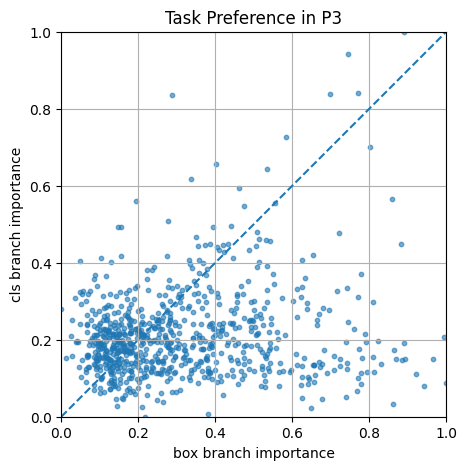

In [86]:
import matplotlib.pyplot as plt

np_weight_box_0_scale_out = weight_box_0_scale_out.detach().cpu().numpy()
np_weight_cls_0_dw_scale_out = weight_cls_0_conv_scale_out.detach().cpu().numpy()

np_weight_box_0_scale_out = (np_weight_box_0_scale_out-np_weight_box_0_scale_out.min())/(np_weight_box_0_scale_out.max()-np_weight_box_0_scale_out.min())
np_weight_cls_0_dw_scale_out = (np_weight_cls_0_dw_scale_out-np_weight_cls_0_dw_scale_out.min())/(np_weight_cls_0_dw_scale_out.max()-np_weight_cls_0_dw_scale_out.min())

box = np_weight_box_0_scale_out
cls = np_weight_cls_0_dw_scale_out

print((box>cls).sum()) # P3: 284, P4: 430, P5: 473
plt.figure(figsize=(5,5))
plt.scatter(box, cls, s=10, alpha=0.6)
plt.title('Task Preference in P3')
plt.xlabel("box branch importance")
plt.ylabel("cls branch importance")

# y = x 的對角線
lims = [
    min(box.min(), cls.min()),
    max(box.max(), cls.max()),
]
plt.plot(lims, lims, linestyle="--")
plt.xlim(lims)
plt.ylim(lims)
plt.gca().set_aspect("equal", "box")
plt.grid(True)
plt.show()
